Customize: Custom Mask
======================

This example demonstrates how to use a custom mask (tailored to the lensed source galaxy's light distribution)
in a model-fit.

**Benefits:** Strong lenses with complex and difficult-to-subtract foreground lens galaxies can leave residuals that
bias the mass and source models, which this custom mask can remove from the model-fit. The custom mask can also provide
faster run times, as the removal of large large regions of the image (which contain no signal) no longer need to be
processed and fitted.

**Downsides:**  Pixels containing no source emission may still constrain the lens model, if a mass model incorrectly
predicts that flux will appear in these image pixels. By using a custom mask, the model-fit will not be penalized for
incorrectly predicting flux in these image-pixels (As the mask has removed them from the fit).

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset__

Load and plot the strong lens dataset `mass_sie__source_sersic` via .fits files, which we will fit with the lens model.

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
)

__Masking__

We will load the mask from a .fits file, like we did `Imaging` above. 

To create the .fits file of a mask, we use a GUI tool which is described in the following script:

 `autolens_workspace/notebooks/preprocess/imaging/gui/mask.py`

In [3]:
mask_custom = al.Mask2D.from_fits(
    file_path=path.join(dataset_path, "mask_gui.fits"),
    hdu=0,
    pixel_scales=imaging.pixel_scales,
)

imaging = imaging.apply_mask(mask=mask_custom)  # <----- The custom mask is used here!

When we plot the `Imaging` dataset with the mask it extracts only the regions of the image in the mask remove 
contaminating bright sources away from the lens and zoom in around the mask to emphasize the lens.

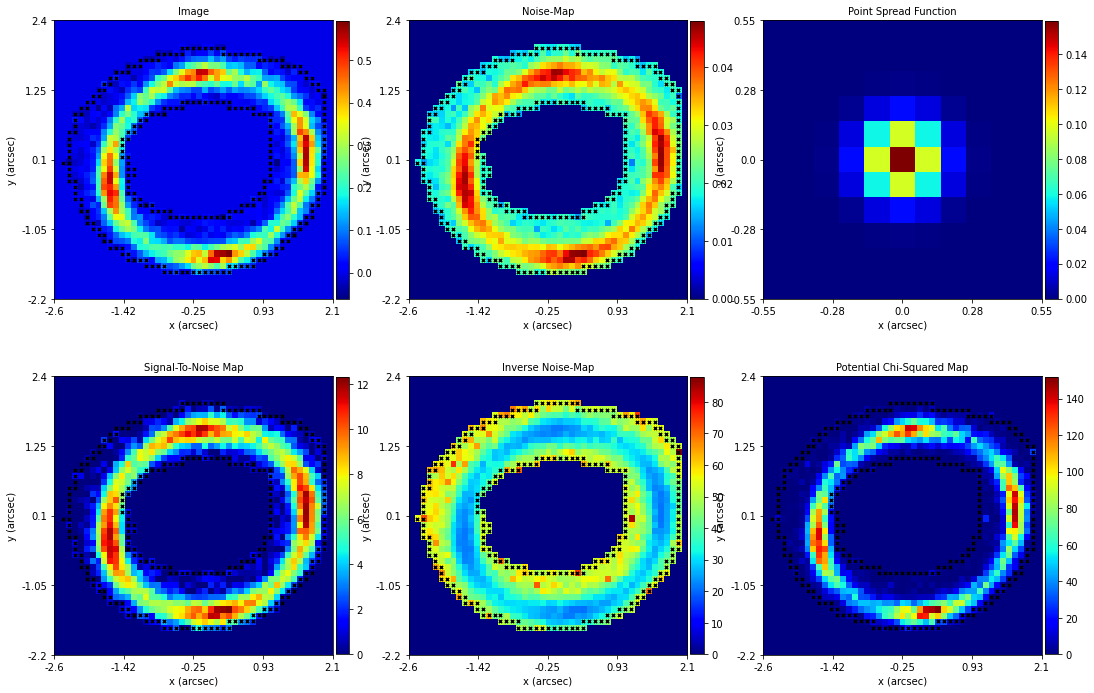

In [4]:
visuals_2d = aplt.Visuals2D(mask=mask_custom)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.subplot_imaging()

__Model + Search + Analysis__ 

The code below performs the normal steps to set up a model-fit. We omit comments of this code as you should be 
familiar with it and it is not specific to this example!

In [5]:
lens = af.Model(al.Galaxy, redshift=0.5, mass=al.mp.EllIsothermal)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

search = af.DynestyStatic(
    path_prefix=path.join("imaging", "customize"), name="custom_mask"
)

analysis = al.AnalysisImaging(dataset=imaging)

__Model-Fit__

We can now begin the model-fit by passing the model and analysis object to the search, which performs a non-linear
search to find which models fit the data with the highest likelihood.

Because the `AnalysisImaging` was passed a `Imaging` with the custom mask, this mask is used by the model-fit.

In [6]:
result = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 10.79it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.059]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Result__

By plotting the maximum log likelihood `FitImaging` object we can confirm the custom mask was used.

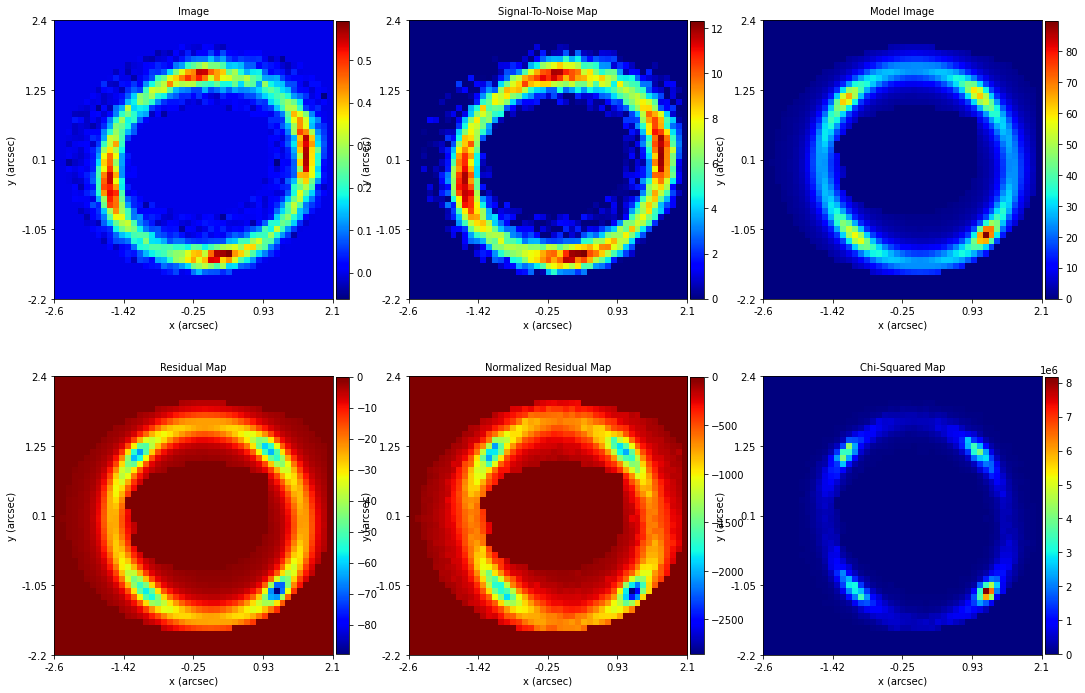

In [7]:
fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

Finish.